# GNN

Dieses Notebook ist ein erster Test des GNN Ansatzes für die Vorhersage von $\mu$ und $\sigma$

In [5]:
# Set Notebook Name for WandB
import os
os.environ['WANDB_NOTEBOOK_NAME'] = 'gnn.ipynb'
import sys
sys.path.append('../utils')

In [6]:
from helpers import load_data, load_stations, clean_data, normalize_data, create_data, visualize_graph
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv, Sequential, summary
from torch_geometric.utils import to_networkx
from torch.nn import Linear, Embedding, Dropout, ModuleList
from tqdm import tqdm, trange

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopy.distance
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import wandb

%matplotlib inline
plt.style.use('default')

## Import of Data

In [7]:
# Get Data from feather
data = load_data(indexed=False)
# Get List of stations with all stations -> will break further code if cut already
stations = load_stations(data)
# Clean Data
data = clean_data(data, max_missing=121, max_alt=1000.0)
# Normalize Data
normalized_data = normalize_data(data, last_obs=-365) #last_obs is -365 since the last year is used for testing

## Create the torch dataset

The Dataset which is a `pandas.DataFrame` gets converted to a `torch_geometric.data` object, which then can be processed by the GNN

#### ⚠️ TODO



In [4]:
#dist_matrix = compute_dist_matrix(stations)
#np.save(dist_matrix, 'dist_matrix.npy')

In [8]:
# TODO set the maximum distance (might want to get this from a configuration file)
max_dist = 50

dist_matrix = np.load('dist_matrix.npy')

# Create a boolean mask indicating which edges to include
mask = (dist_matrix <= max_dist) & (dist_matrix != 0)

torch_data = []
for date in tqdm(data['date'].unique()):
    torch_data.append(create_data(df=normalized_data, date=date, mask=mask, dist_matrix=dist_matrix))

 93%|█████████▎| 3298/3530 [00:21<00:01, 153.81it/s]


KeyboardInterrupt: 

### Dataloaders

In [6]:
# TODO another hyperparameter here
BS = 128

# Definition of train_loader and valid_loader
train_loader_small = DataLoader(torch_data[:365], batch_size=BS, shuffle=True)
train_loader = DataLoader(torch_data[:-730], batch_size=BS, shuffle=True)
train_loader_full = DataLoader(torch_data[:-365], batch_size=BS, shuffle=True)
valid_loader = DataLoader(torch_data[-730:-365], batch_size=BS, shuffle=True)
test_data = torch_data[-365:]
test_loader = DataLoader(test_data, batch_size=BS, shuffle=True)

### Visualizations of Graph to test if everything worked fine

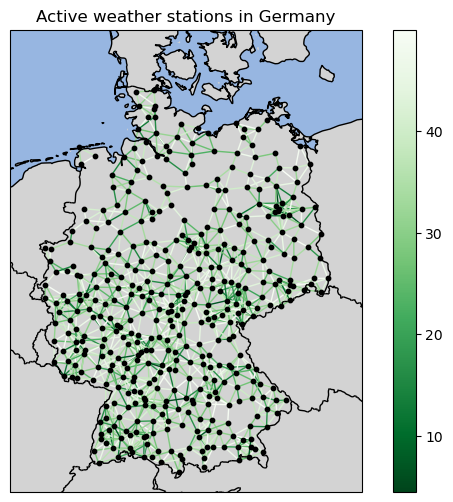

In [7]:
visualize_graph(torch_data[100], df=data, last_obs=-365)

## GNN

In the following section the gnn is constructed. This is largely based on the [PyG Colab Notebooks](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing).

#### ⚠️ TODO
 - Modularize -> use multiple torch.modules in a Sequential model
 - Early stopping should save model checkpoint
 - gin config
 - [Neural Tangent Kernel](https://en.wikipedia.org/wiki/Neural_tangent_kernel)
 - Attention weights mitteln und anschauen (Kanten in Graph einfärben)
 - W&B hinzufügen
 - Check out GNN explainer
 - Hyperparameter Optimization
 - Test different Layers and Architectures
    - Embed Node ID (wie in paper von Sebastian)
    - ResNet (Recidual Layer)
    - Softplus for sigma
    - Edge Weights
    - Try Out New Layer Types

### CRPS Loss Function

\begin{align*}

    \operatorname{crps}(F,X)=&\int_{-\inf}^{\inf}\left(F(y)-\boldsymbol{1}_{(y-x)}\right)^2dy\\

\end{align*}

Closed form expression from Gneiting et al. (2005)

\begin{align*}

    \operatorname{crps}\left(\mathcal{N}\left(\mu, \sigma^2\right), y\right)= & \sigma\left\{\frac{y-\mu}{\sigma}\left[2 \Phi\left(\frac{y-\mu}{\sigma}\right)-1\right] +2 \varphi\left(\frac{y-\mu}{\sigma}\right)-\frac{1}{\sqrt{\pi}}\right\}

\end{align*}

$\Phi\left(\frac{y-\mu}{\sigma}\right)$ denotes the CDF of a standard normal distribution and $\varphi\left(\frac{y-\mu}{\sigma}\right)$ denotes the PDF of a standard normal distribution

In [8]:
def crps(mu: torch.tensor, sigma: torch.tensor, y: torch.tensor):
    """Calculates the Continuous Ranked Probability Score (CRPS) assuming normally distributed df

    Args:
        mu (torch.tensor): mean
        sigma (torch.tensor): standard deviation
        y (torch.tensor): observed df

    Returns:
        torch.tensor: CRPS value
    """
    y = y.view((-1,1)) # make sure y has the right shape
    PI = np.pi #3.14159265359
    omega = (y - mu) / sigma
    # PDF of normal distribution at omega
    pdf = 1/(torch.sqrt(torch.tensor(2 * PI))) * torch.exp(-0.5 * omega ** 2)
    
    # Source: https://stats.stackexchange.com/questions/187828/how-are-the-error-function-and-standard-normal-distribution-function-related
    cdf = 0.5 * (1 + torch.erf(omega / torch.sqrt(torch.tensor(2))))
    
    crps = sigma * (omega * (2 * cdf - 1) + 2 * pdf - 1/torch.sqrt(torch.tensor(PI)))
    return  torch.mean(crps)

### GNN
Definition of Model and Training

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
class Convolution(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels, heads, num_layers:int=None):
        super(Convolution, self).__init__()
        # Make sure either hidden_channels is a list, heads is a list or num_layer is supplied
        assert isinstance(hidden_channels, list) or isinstance(heads, list) or num_layers is not None,\
                "If hidden_channels is not a list, num_layers must be specified."
        # both are a list
        if isinstance(hidden_channels, list) and isinstance(heads, list):
            assert len(hidden_channels) == len(heads), f"Lengths of lists {len(hidden_channels)} and {len(heads)} do not match."
        # only hidden_channels is list
        if isinstance(hidden_channels, list) and not isinstance(heads, list):
            heads = [heads] * len(hidden_channels)
        # only heads is list
        if isinstance(heads, list) and not isinstance(hidden_channels, list):
            hidden_channels = [hidden_channels] * len(heads)
        # none is list
        if not isinstance(heads, list) and not isinstance(hidden_channels, list):
            heads = [heads] * num_layers
            hidden_channels = [hidden_channels] * num_layers
        # definition of Layers
        self.convolutions = ModuleList()
        for c, h in zip(hidden_channels, heads):
            self.convolutions.append(GATConv(in_channels=-1, out_channels=c, heads=h))
        # Last Layer to match shape of output
        self.lin = Linear(in_features=hidden_channels[-1] * heads[-1], out_features=out_channels)

    def forward(self, x, edge_index, edge_attr):
        for conv in self.convolutions:
            x = F.relu(conv(x, edge_index, edge_attr))
        x = F.relu(self.lin(x))
        return x


class EmbedStations(torch.nn.Module):
    def __init__(self, num_stations_max, embedding_dim):
        super(EmbedStations, self).__init__()
        self.embed = Embedding(num_embeddings=num_stations_max, embedding_dim=embedding_dim)

    def forward(self, x):
        station_ids = x[:, 0].long()
        emb_station = self.embed(station_ids)
        x = torch.cat((emb_station, x[:, 1:]), dim=1) # Concatenate embedded station_id to rest of the feature vector
        return x


class MakePositive(torch.nn.Module):
    def __init__(self):
        super(MakePositive, self).__init__()

    def forward(self, x):
        mu, sigma = torch.split(x, 1, dim=-1)
        sigma = F.softplus(sigma) # ensure that sigma is positive
        return mu, sigma
    
class ResGnn(torch.nn.Module):
    def __init__(self, in_channels, out_channels, num_layers, hidden_channels, heads):
        super(ResGnn, self).__init__()
        assert num_layers > 0, "num_layers must be > 0."

        # Create Layers
        self.convolutions = ModuleList()
        for i in range(num_layers):
            if i == 0:
                self.convolutions.append(GATv2Conv(in_channels, hidden_channels, heads=heads, edge_dim=1))
            else:
                self.convolutions.append((GATv2Conv(-1, hidden_channels, heads=heads, edge_dim=1)))
        self.lin = Linear(hidden_channels * heads, out_channels) #hier direkt 2 testen

    def forward(self, x, edge_index, edge_attr):
        x = x.float()
        edge_attr = edge_attr.float()
        #TODO add edge_attrs here
        for i, conv in enumerate(self.convolutions):
            if i == 0:
                # First Layer
                x = conv(x, edge_index, edge_attr)
                x = F.relu(x)
            else:
                x = x + F.relu(conv(x, edge_index, edge_attr)) # Residual Layers

        x = self.lin(x)
        x = F.relu(x)
        return x

In [11]:
class GNNOld(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, heads):
        super(GNNOld, self).__init__()
        #self.emb = Embedding(num_embeddings=531, embedding_dim=8)
        self.conv0 = GATConv(num_features, hidden_channels, heads=heads) #Layers mit edge attributes
        self.conv1 = GATConv(-1, hidden_channels, heads=heads)
        self.conv2 = GATConv(-1, hidden_channels, heads=heads)
        self.conv3 = GATConv(-1, hidden_channels, heads=heads)
        self.conv4 = GATConv(-1, hidden_channels, heads=heads)
        self.lin1 = torch.nn.Linear(hidden_channels * heads, 512) #hier direkt 2 testen
        self.lin2 = torch.nn.Linear(512, 2)

    def forward(self, x, edge_index):
        x = self.conv0(x, edge_index)
        x = F.relu(x)
        x = x + F.relu(self.conv1(x, edge_index)) # Resnet
        x = x + F.relu(self.conv2(x, edge_index)) # Resnet
        x = x + F.relu(self.conv3(x, edge_index)) # Resnet
        x = x + F.relu(self.conv4(x, edge_index)) # Resnet
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        mu, sigma = torch.split(x, 1, dim=-1)
        sigma = F.softplus(sigma) # ensure that sigma is positive
        return mu, sigma

In [12]:
# TODO another parameter
LR = 0.002
EMBED_DIM = 10
Linear_size = 256
hidden_channels = 16
heads = 8
#num_layers = len(heads) if len(heads) > len(hidden_channels) else len(hidden_channels)
num_layers = 2

# Clear Cache
torch.cuda.empty_cache()
# Initialize the model and optimizer
num_features = torch_data[0].num_features

#model = GNNOld(num_features=num_features, hidden_channels=16, heads=8)
model = Sequential('x, edge_index, edge_attr',
                   [
                       (EmbedStations(num_stations_max=535, embedding_dim=EMBED_DIM ), 'x -> x'),
                       (ResGnn(in_channels=-1, out_channels=Linear_size, hidden_channels=hidden_channels, heads=heads, num_layers=num_layers), 'x, edge_index, edge_attr -> x'),
                       #(Convolution(in_channels=-1, out_channels=Linear_size, hidden_channels=hidden_channels, heads=heads), 'x, edge_index, edge_attr -> x'),
                       (Linear(Linear_size, 2),'x -> x'),
                       (MakePositive(), 'x -> mu, sigma')
                   ])


model.to(device)
#torch_geometric.compile(model)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR) #momentum anschauen

In [13]:
log_WandB = True

In [14]:
#TODO more hyperparams here
n_epochs = 100
patience = 30
best_val_loss = float('inf')

no_improvement = 0

if log_WandB:
    wandb.init(
    # set the wandb project where this run will be logged
        project="GNNPP",
        
        # track hyperparameters and run metadata
        config={
        "learning_rate": LR,
        "architecture": "ResNetv2",
        "embed_dim": EMBED_DIM,
        "num_layers": num_layers,
        "hidden_channels": hidden_channels,
        "heads": heads,
        "max_epochs": n_epochs,
        "patience": patience,
        "batch_size": BS,
        "max_dist": max_dist
        }
    )


def train(batch):
    batch.to(device)
    optimizer.zero_grad()
    out = model(batch.x, batch.edge_index, batch.edge_attr)
    mu, sigma = out
    loss = crps(mu, sigma, batch.y)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def valid(batch):
    batch.to(device)
    out = model(batch.x, batch.edge_index, batch.edge_attr)
    mu, sigma = out
    loss = crps(mu, sigma, batch.y)
    return loss


train_losses = []
validation_losses = []

# loading bar
epochs_pbar = trange(n_epochs, desc="Epochs")

for epoch in epochs_pbar:
    # Train for one epoch
    model.train()
    train_loss = 0.0
    
    for batch in train_loader:
        loss = train(batch)
        train_loss += loss.item() * batch.num_graphs
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
        
    # Evaluate on the validation set
    model.eval()
    val_loss = 0.0
    
    for batch in valid_loader:
        loss = valid(batch)
        val_loss += loss.item() * batch.num_graphs
    val_loss /= len(valid_loader.dataset)
    validation_losses.append(val_loss)

    # Log to WandB
    if log_WandB:
        wandb.log({"train_loss": train_loss, "val_loss": val_loss})
    
    # Check if the validation loss has improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement = 0
        # Save model checkpoint
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, "checkpoint.pt")
    else:
        no_improvement += 1
    
    epochs_pbar.set_postfix({"Train Loss": train_loss, "Val Loss": val_loss,"Best Loss": best_val_loss, "No Improvement": no_improvement})
    # Early stopping
    if no_improvement == patience:
        print('Early stopping.')
        break
if log_WandB:
    wandb.log({"best_val_loss": best_val_loss, "trained_epochs":  epoch-patience})

# Load weights from model checkpoint
checkpoint = torch.load("checkpoint.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# Set model to eval mode
model.eval()

wandb: Currently logged in as: feik. Use `wandb login --relogin` to force relogin


Epochs: 100%|██████████| 100/100 [06:54<00:00,  4.14s/it, Train Loss=0.735, Val Loss=0.871, Best Loss=0.848, No Improvement=2]


Sequential(
  (0): EmbedStations(
  (embed): Embedding(535, 10)
)
  (1): ResGnn(
  (convolutions): ModuleList(
    (0-1): 2 x GATv2Conv(-1, 16, heads=8)
  )
  (lin): Linear(in_features=128, out_features=256, bias=True)
)
  (2): Linear(in_features=256, out_features=2, bias=True)
  (3): MakePositive()
)

In [15]:
print(summary(model, x=torch_data[1000].x.to(device), edge_index=torch_data[1000].edge_index.to(device), edge_attr=torch_data[1000].edge_attr.to(device)))

+---------------------------------+----------------------------------+--------------------+----------+
| Layer                           | Input Shape                      | Output Shape       | #Param   |
|---------------------------------+----------------------------------+--------------------+----------|
| Sequential_650af9               |                                  | [472, 1], [472, 1] | 85,992   |
| ├─(module_0)EmbedStations       | [472, 42]                        | [472, 51]          | 5,350    |
| │    └─(embed)Embedding         | [472]                            | [472, 10]          | 5,350    |
| ├─(module_1)ResGnn              | [472, 51], [2, 4338], [4338, 1]  | [472, 256]         | 80,128   |
| │    └─(convolutions)ModuleList | --                               | --                 | 47,104   |
| │    │    └─(0)GATv2Conv        | [472, 51], [2, 4338], [4338, 1]  | [472, 128]         | 13,696   |
| │    │    └─(1)GATv2Conv        | [472, 128], [2, 4338], [4338, 1] | [4

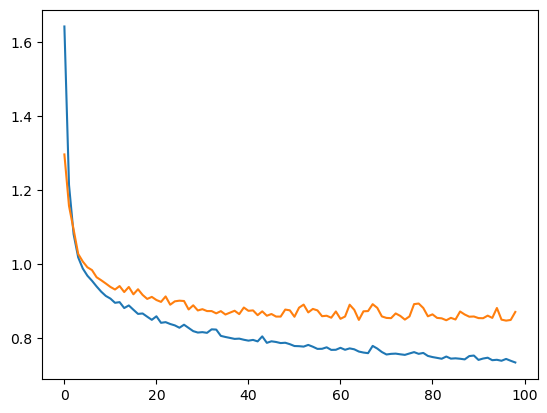

In [16]:
plt.plot(train_losses[1:])
plt.plot(validation_losses[1:])

### Evaluation
Calculation of CRPS on test set and graphical diagnostics

In [17]:
model.eval()
mu_list = []
sigma_list = []
err_list = []
y_list = []


for batch in test_loader:
    batch.to(device)
    mu, sigma = model(batch.x, batch.edge_index, batch.edge_attr)
    y = batch.y
    err = crps(mu, sigma, y)
    mu = mu.detach().cpu().numpy().flatten()
    sigma = sigma.detach().cpu().numpy().flatten()
    y = y.cpu().numpy()
    err = err.detach().cpu().numpy()

    mu_list.append(mu)
    sigma_list.append(sigma)
    y_list.append(y)
    err_list.append(err*len(batch))

err = sum(err_list) / len(test_loader.dataset)
mu = np.concatenate(mu_list)
sigma = np.concatenate(sigma_list)
y = np.concatenate(y_list)

Text(0.5, 1.0, 'Predicted vs. observed temperatures\nCRPS=0.8086')

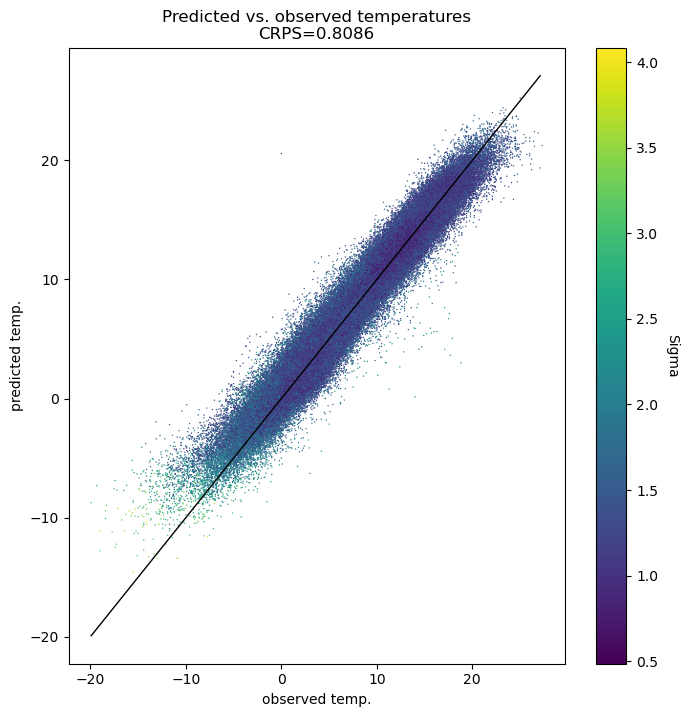

In [18]:
plt.figure(figsize=(8,8))
plt.plot(np.arange(np.min(y),np.max(y),1), np.arange(np.min(y),np.max(y),1), linewidth=1, color="black")
plt.scatter(y, mu, c=sigma, s=1, linewidth=0, cmap="viridis")

cbar = plt.colorbar()
cbar.set_label('Sigma', rotation=270, labelpad=15)
plt.xlabel('observed temp.')
plt.ylabel('predicted temp.')
plt.title(f"Predicted vs. observed temperatures\nCRPS={err:.4f}")

In [19]:
if log_WandB:
    # save code
    wandb.save("gnn.ipynb")
    wandb.save("helpers.py")
    # finish logging
    wandb.finish()

best_val_loss,▁
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trained_epochs,▁
val_loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_loss,0.84778
train_loss,0.73464
trained_epochs,69
val_loss,0.87123
